In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


In [481]:
path = "../data/clean"
patient_df = pd.read_pickle(f"{path}/patient_level_features_med_num.pkl")
df = pd.read_pickle(f"{path}/feature_ls.pkl")
X_pca = np.load(f"{path}/X_pca.npy")
#labels = np.load(f"{path}/labels.npy")
df_unsup = pd.read_pickle(f"{path}/df_unsupervised_final.pkl")

In [569]:
# readin hcpcs mapper
mapper_path = "../data/mappers"
hcpcs_mapper = pd.read_pickle(f"{mapper_path}/hcpcs.pkl")
drg_mapper = pd.read_pickle(f"{mapper_path}/drg.pkl")
icd10_mapper = pd.read_pickle(f"{mapper_path}/icd10.pkl")

In [466]:
drg_mapper.head()

,DRG,MDC,DRG_description,MDC_description
0,001,NaN,Heart transplant or implant of heart assist sy...,NaN
1,002,NaN,Heart transplant or implant of heart assist sy...,NaN
2,003,NaN,ECMO o r tracheostomy with MV >96 hours or PDX...,NaN
3,004,NaN,Trache ostomy with MV >96 hours or PDX except ...,NaN
4,005,NaN,Liver transplant with MCC or intestinal transp...,NaN


In [467]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
      
    if model_type == 'dbscan':
            unique_labels = set(labels)
            n_clusters = len([l for l in unique_labels if l != -1])
             
    colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
    
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        centers = model.means_
    elif model_type == 'dbscan':
        centers = []
        for label in unique_labels:
            if label == -1:
                continue  # skip noise
            cluster_points = X_pca[labels == label]
            centers.append(list(cluster_points.mean(axis=0)))
            
    # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        cl = i * 1.5
        axis.scatter(c[0], c[1], 
                marker="$%d$" % (i + 1), 
                alpha=1, s=20, 
                color = cm.jet( (cl ) / (n_clusters)))
        axis.set_title("K-Means Clustering Results")
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [483]:
df_desc = pd.merge(df, hcpcs_mapper, how = 'left', left_on = 'feature', right_on = 'Code')

In [484]:
df_desc

,component,feature,Code,Description
0,PC1,G0153,G0153,Services performed by a qualified speech-langu...
1,PC2,G9857,G9857,Patient admitted to hospice\nTerminated Decemb...
2,PC3,G8946,G8946,Minimally invasive biopsy method attempted but...
3,PC4,H2000,H2000,Comprehensive multidisciplinary evaluation
4,PC5,G8111,NaN,NaN
5,PC6,S9473,S9473,"Pulmonary rehabilitation program, non-physicia..."
6,PC7,S0605,NaN,NaN
7,PC8,G8111,NaN,NaN
8,PC9,G9708,G9708,Women who had a bilateral mastectomy or who ha...
9,PC10,T1502,T1502,"Administration of oral, intramuscular and/or s..."


In [485]:
kmeans = KMeans(init = 'k-means++', n_clusters=8, n_init= 5, random_state = 42) 
km = kmeans.fit(X_pca) 
labels = km.predict(X_pca)

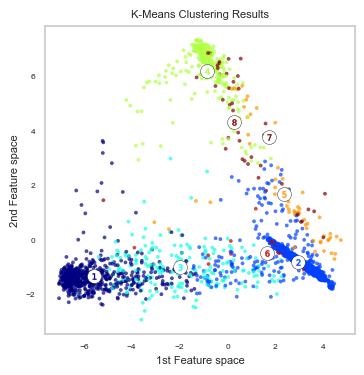

In [471]:
# fig, ax = plt.subplots(figsize=(4, 4))
# create_cluster_plot(labels, 8, X_pca, km, ax, model_type = 'km')

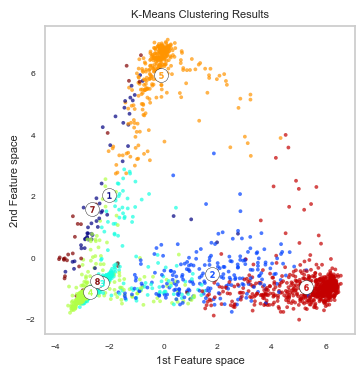

In [486]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 8, X_pca, km, ax, model_type = 'km')

Look at patients with the most relevant PCA features in combined_hcpcs_ls

In [487]:
ls = [x for x in df_desc['feature']]
ls

['G0153',
 'G9857',
 'G8946',
 'H2000',
 'G8111',
 'S9473',
 'S0605',
 'G8111',
 'G9708',
 'T1502',
 'G0458']

In [488]:
df_unsup['cluster'].value_counts()

cluster
3    699
2    676
5    623
4    321
1    206
0     53
6     24
7      5
Name: count, dtype: int64

In [540]:
# merge on cluster
df_eval = pd.concat([patient_df, df_unsup], axis = 1)

In [541]:
mask = df_eval['combined_hcpcs_ls'].apply(lambda x:list( set([1 for code in x if code in ls]))).apply(lambda x: 1 if len(x) > 0 else 0)

In [542]:
mask.unique()

array([0, 1])

In [543]:
# limit to rows that have hcpcs code in it
df_eval = df_eval[ mask == 1]

In [551]:
df_eval['cluster'].value_counts()

cluster
5    621
4    316
1    203
3    101
2     90
0     53
6     24
7      5
Name: count, dtype: int64

In [552]:
df_eval.head()

,patient_medicare_number,gender,age,number_of_claims,preventative_care_ind,combined_hcpcs_ls,combined_diagnosis_ls,combined_principal_diagnosis_ls,drg_ls,total_value,...,HCPCS_level_2,HCPCS_level_1,Alcohol and Drug Abuse Treatment,Temporary National Codes (Non-Medicare),Outpatient PPS,Temporary Codes,National Codes Established for State Medicaid Agencies,Procedures/Professional Services,Evaluation and Management (E/M) Codes,cluster
9,1S00E00AA53,0,76.0,51,1,"[G8111, 99241, 99221, 99241, 99241, G0444, 992...","[E669, I10, O039, C50929, E669, I10, O039, C50...","[C50929, C50919, J45909, J45909, C50929, C5091...","[003, 001, 003, 003, 003, 003, 003, 003, 003, ...",250.43,...,0.545651,0.838012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,1S00E00AA54,0,74.0,228,1,"[99241, 99241, 99241, G0444, 99241, G0444, 992...","[E119, R739, E781, E8881, D649, E11319, I10, O...","[Z3480, Z3480, Z3480, Z3480, Z3480, Z3480, Z34...","[001, 001, 001, 001, 001, 001, 001, 001, 001, ...",278.58,...,0.405099,0.914273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
11,1S00E00AA57,0,79.0,18,1,"[99241, 99221, G0444, G0444, 99241, G0444, 992...","[D649, E669, J209, S93409, D649, E669, D649, E...","[J209, S93409, J0190, J0190, F0280, B9789, B97...",[001],11633.86,...,0.979352,0.202163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
12,1S00E00AA60,1,79.0,47,1,"[G0444, 99241, S8075, 99241, 99241, G0444, 992...","[E669, D649, C50929, E669, D649, C50919, E669,...","[C50919, C50929, C50919, C50919, C50929, C5091...","[003, 003, 003, 003, 003, 003, 003, 001, 003, ...",142.58,...,0.945909,0.324431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
19,1S00E00AA80,1,79.0,73,1,"[G0444, 99241, 99241, 99241, 99241, 99241, 992...","[T50904, J329, D649, J441, E785, T50904, J329,...","[E785, E785, E785, E785, E785, E785, E785, E78...","[001, 002, 001, 002, 001, 003, 003, 003, 003]",234.72,...,0.200826,0.979627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [564]:
# create principal diagnosis list by cluster
grp = df_eval.groupby('cluster')['combined_principal_diagnosis_ls'].apply(list)
grp_df_principal = pd.DataFrame(grp)
grp_df_principal.reset_index(inplace=True)
grp_df_principal

,cluster,combined_principal_diagnosis_ls
0,0,"[[C50929, C50919, J45909, J45909, C50929, C509..."
1,1,"[[M810, M810, M810, M810, M810, M810, M810, M8..."
2,2,"[[E785, B002, E785, E785, E785, E785, B085, J0..."
3,3,"[[Z3480, Z3480, Z3480, Z3480, Z3480, Z3480, Z3..."
4,4,"[[J209, S93409, J0190, J0190, F0280, B9789, B9..."
5,5,"[[E785, N390, E785, E785, E785, E785, E785, E7..."
6,6,"[[J329, J329, C50929, C50919, C50929, C50929, ..."
7,7,"[[J0190, J0190, J0190, J0190, J0190, J0190, J0..."


In [565]:
# create unique principal diagnosis list by cluster
grp_df_principal['unique_prinicpal_ls'] = grp_df_principal['combined_principal_diagnosis_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [571]:
grp_df_principal.head()

,cluster,combined_principal_diagnosis_ls,unique_prinicpal_ls,principal_drg_ls_len,word_cloud
0,0,"[[C50929, C50919, J45909, J45909, C50929, C509...","[O00101, S51819, M797, E785, J029, S8290X, P29...",60,"{'Complete', 'pregnancy', 'Oth', 'viral', 'ove..."
1,1,"[[M810, M810, M810, M810, M810, M810, M810, M8...","[I50810, I4891, T148XX, H6690, I50813, P2981, ...",111,"{'Oth', 'viral', 'overlapping', 'Streptococcus..."
2,2,"[[E785, B002, E785, E785, E785, E785, B085, J0...","[I50810, T148XX, I50813, I4891, H6690, U071, I...",86,"{'Oth', 'viral', 'overlapping', 'Streptococcus..."
3,3,"[[Z3480, Z3480, Z3480, Z3480, Z3480, Z3480, Z3...","[I50810, I4891, I50813, T148XX, P2981, H6690, ...",91,"{'Rectal', 'Oth', 'viral', 'Metabolic', 'overl..."
4,4,"[[J209, S93409, J0190, J0190, F0280, B9789, B9...","[I50810, H6690, T148XX, I4891, P2981, I50813, ...",121,"{'Residual', 'Rectal', 'Oth', 'viral', 'overla..."


In [567]:
# look at lengths of unqiue principal diagnosis list
grp_df_principal['principal_drg_ls_len'] = grp_df_principal['unique_prinicpal_ls'].str.len()
vals = grp_df_principal['principal_drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
principal_drg_ls_len,
60,1
111,1
86,1
91,1
121,1
138,1
36,1
17,1


In [556]:
# create principal diagnosis list by cluster
grp = df_eval.groupby('cluster')['drg_ls'].apply(list)
grp_df = pd.DataFrame(grp)
grp_df.reset_index(inplace=True)
grp_df

,cluster,drg_ls
0,0,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,..."
1,1,"[[975], [], [922, 923, 012, 159, 923, 950, 949..."
2,2,"[[001, 003], [001], [], [001], [], [964, 444],..."
3,3,"[[001, 001, 001, 001, 001, 001, 001, 001, 001,..."
4,4,"[[001], [003, 003, 003, 003, 003, 003, 003, 00..."
5,5,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9..."
6,6,"[[003, 003, 003, 003, 003, 003, 003, 003, 003,..."
7,7,"[[001, 001, 003, 003, 003, 003, 003, 003, 003,..."


In [557]:
# create unique drg list by cluster
grp_df['unique_drg_ls'] = grp_df['drg_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [508]:
# look at length of drg list
grp_df['unique_drg_ls_len'] = grp_df['unique_drg_ls'].str.len()
vals = grp_df['drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
drg_ls_len,
53,1
203,1
90,1
101,1
316,1
621,1
24,1
5,1


In [558]:
grp_df.head(10)

,cluster,drg_ls,unique_drg_ls
0,0,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,...","[817, 583, 812, 305, 818, 565, 374, 376, 641, ..."
1,1,"[[975], [], [922, 923, 012, 159, 923, 950, 949...","[011, 605, 302, 812, 305, 565, 375, 791, 374, ..."
2,2,"[[001, 003], [001], [], [001], [], [964, 444],...","[812, 193, 865, 565, 204, 153, 376, 641, 562, ..."
3,3,"[[001, 001, 001, 001, 001, 001, 001, 001, 001,...","[690, 583, 011, 302, 305, 812, 865, 375, 791, ..."
4,4,"[[001], [003, 003, 003, 003, 003, 003, 003, 00...","[583, 812, 024, 375, 791, 013, 535, 864, 019, ..."
5,5,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9...","[583, 090, 812, 024, 871, 375, 791, 298, 013, ..."
6,6,"[[003, 003, 003, 003, 003, 003, 003, 003, 003,...","[583, 872, 871, 024, 812, 791, 918, 153, 641, ..."
7,7,"[[001, 001, 003, 003, 003, 003, 003, 003, 003,...","[003, 001]"


In [559]:
grp_df_cloud = grp_df.copy()

In [560]:
# create work cloud column of diagnosis descriptions

for index, row in grp_df_cloud.iterrows():
    print(index)
    #print(row['principal_unq'])
    if len(row['unique_drg_ls']) > 1:
        row_ls = []
        for code in row['unique_drg_ls']:
            #print(code)
            if drg_mapper['DRG'].isin([code]).any():
                ind = drg_mapper[drg_mapper['DRG'].str.contains(code)].index[0].item()
                #print(ind)
                text = drg_mapper.loc[ind, 'MDC_description']
                #print(f"text {text}")
                if type(text) == str:
                    text = text.replace('DISEASES & DISORDERS OF ', '')
                    text = text.replace('DISEASES', '')
                    text = text.replace('DISORDERS', '')
                    text = text.replace('THE ', '')
                    text = text.replace('SYSTEM', '')
                    text = text.replace("'", '')
                    #print(text)
                    #continue
                if type(text) == float:
                    continue
                    #print(f"text nan {text}") 

                row_ls = row_ls + [text]
        print(row_ls)
        grp_df_cloud.at[index, 'word_cloud'] = str(set(row_ls))

    # else:
    #     #print(code)
    #     if icd10_mapper['CODE'].str.contains(code).any():
    #         ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
    #         #print(ind)
    #         text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split( )[0:4]
    #         text = [ word for word in text if word not in ['unspecified', 'Unspecified', 'as', 'of', 'or', 'w', 'w/o', 'Acute', 'Chronic', 'Essential', '(primary)']]
    #         print(f"text {text}")
    #         df_unsupervised.at[index, 'word_cloud'] = str(set(text))

0
['PREGNANCY, CHILDBIRTH & PUERPERIUM', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'BLOOD, BLOOD FORMING ORGANS, IMMUNOLOG DISORD', 'CIRCULATORY ', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'MUSCULOSKELETAL  & CONN TISSUE', 'DIGESTIVE ', 'DIGESTIVE ', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'MUSCULOSKELETAL  & CONN TISSUE', 'RESPIRATORY ', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS', 'RESPIRATORY ', 'NERVOUS ', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'MUSCULOSKELETAL  & CONN TISSUE', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'MUSCULOSKELETAL  & CONN TISSUE', 'MULTIPLE SIGNIFICANT TRAUMA', 'MUSCULOSKELETAL  & CONN TISSUE', 'MULTIPLE SIGNIFICANT TRAUMA', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'PREGNANCY, CHILDBIRTH & PUE

In [561]:
for cloud in grp_df_cloud['word_cloud']:
    print(len(cloud.split(',')))

19
27
25
28
28
29
23
1


In [562]:
for group in grp_df_cloud['word_cloud']:
    print(group)

{'CIRCULATORY ', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'NERVOUS ', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'DIGESTIVE ', 'RESPIRATORY ', 'MUSCULOSKELETAL  & CONN TISSUE', 'MULTIPLE SIGNIFICANT TRAUMA', 'BLOOD, BLOOD FORMING ORGANS, IMMUNOLOG DISORD', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS'}
{'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'CIRCULATORY ', 'HUMAN IMMUNODEFICIENCY VIRUS INFECTIONS', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'NERVOUS ', 'EAR, NOSE, MOUTH & THROAT', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'DIGESTIVE ', 'KIDNEY & URINARY TRACT', 'RESPIRATORY ', 'MUSCULOSKELETAL  & CONN TISSUE', 'MULTIPLE SIGNIFICANT TRAUMA', 'BLOOD, BLOOD FORMING ORGANS, IMMUNOLOG DISORD', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'EYE', 'END

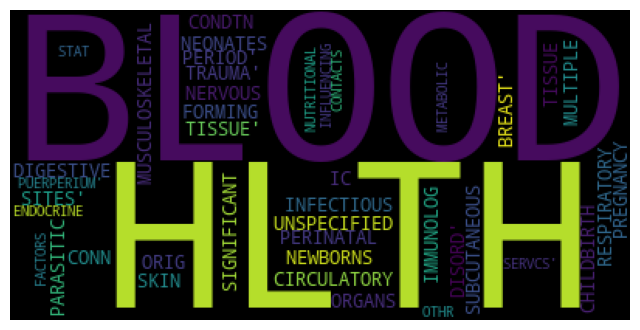

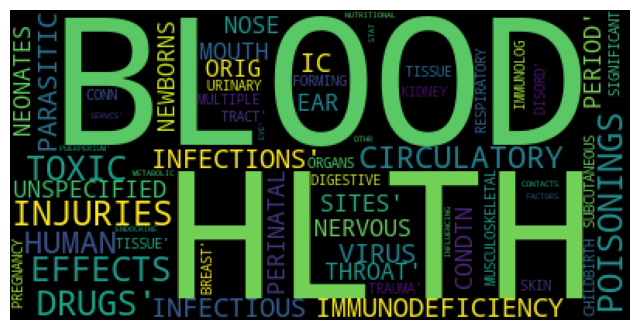

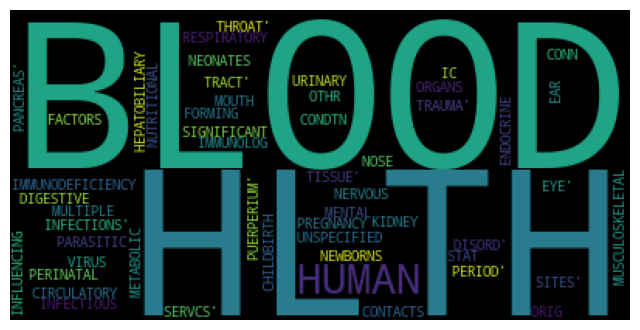

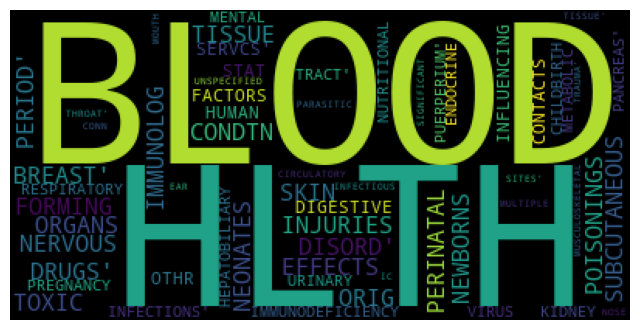

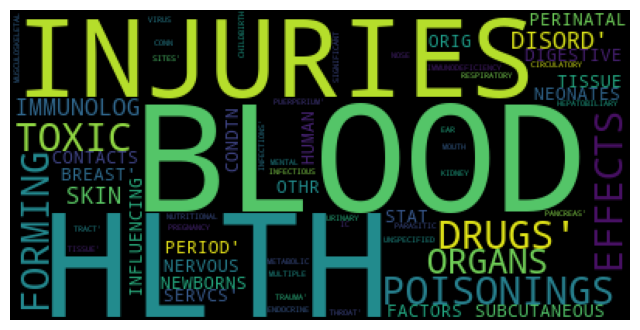

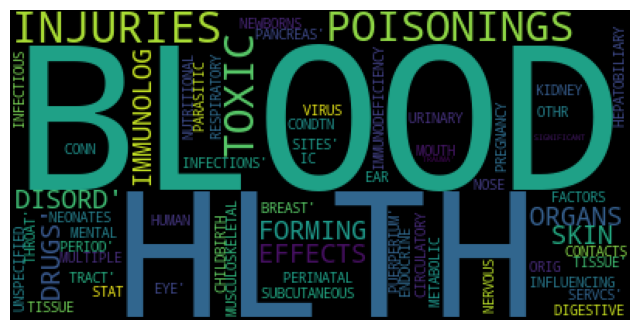

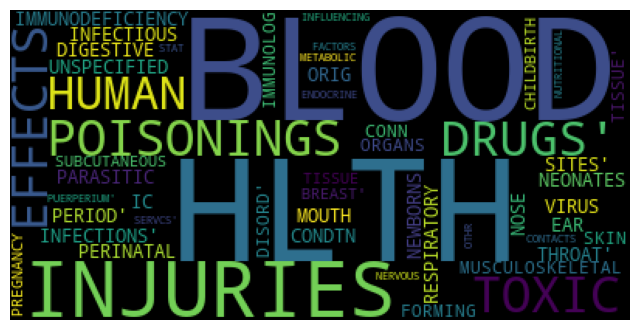

In [539]:
n_clusters = 7
for cluster in range(0,n_clusters):
    df_cluster = grp_df_cloud[grp_df_cloud['cluster'] == cluster]
    diag_cloud = df_cluster['word_cloud'].head(100).apply(str).str.cat(sep=', ')
    #Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(diag_cloud)

    #Use matplotlib.pyplot to display the fitted wordcloud
    #Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [570]:
# create work cloud column of diagnosis descriptions

for index, row in grp_df_principal.iterrows():

    #print(row['principal_unq'])
    if len(row['unique_prinicpal_ls']) > 1:
        row_ls = []
        for code in row['unique_prinicpal_ls']:
            #print(code)
            if icd10_mapper['CODE'].isin([code]).any():
                ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
                #print(ind)
                text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split(' ')[0:4]
                #print(f"text {text}") 
            #row_ls.append(text)
            #print(text)
            row_ls = row_ls + text
        #print(row_ls)
        #row_ls = [ word for word in row_ls if word != ',']
        row_ls = [ word.strip(", '") for word in row_ls if word.strip(", '") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        #print(row_ls)
        grp_df_principal.at[index, 'word_cloud'] = str(set(row_ls))
        # df_unsupervised.at[index, 'word_cloud']= pd.Series([row_ls] * len(df_unsupervised))
        # df_unsupervised.assign(word_cloud =  [row_ls for i in df_unsupervised.index])

    else:
        #print(code)
        if icd10_mapper['CODE'].str.contains(code).any():
            ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
            #print(ind)
            text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split( )[0:4]
            text = [ word for word in text if word not in ['unspecified', 'Unspecified', 'as', 'of', 'or', 'w', 'w/o', 'Acute', 'Chronic', 'Essential', '(primary)']]
            print(f"text {text}")
            grp_df_principal.at[index, 'word_cloud'] = str(set(text))

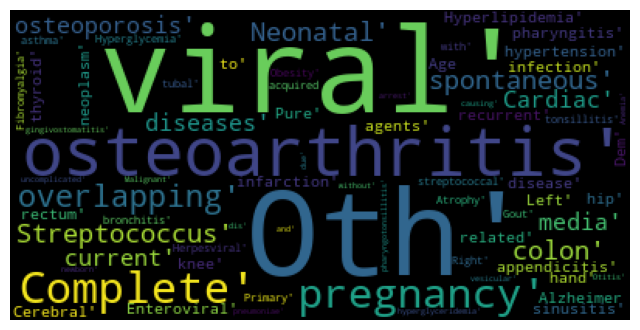

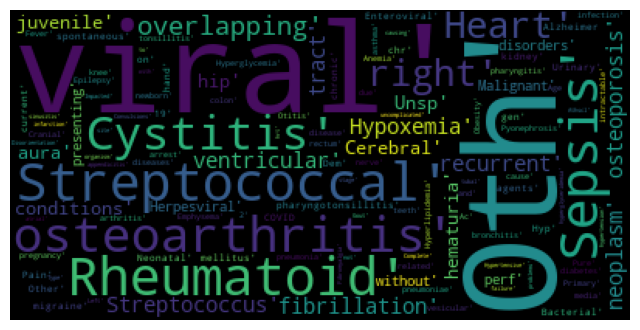

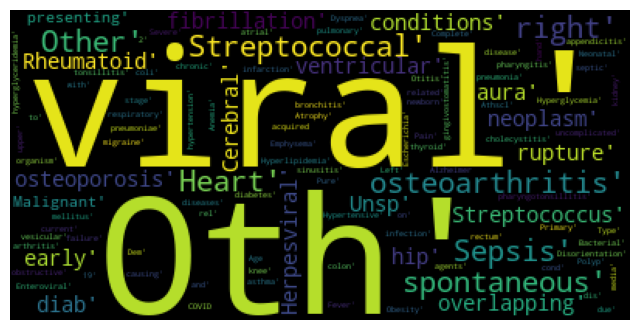

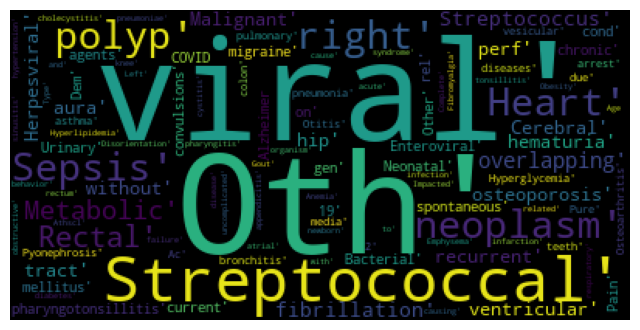

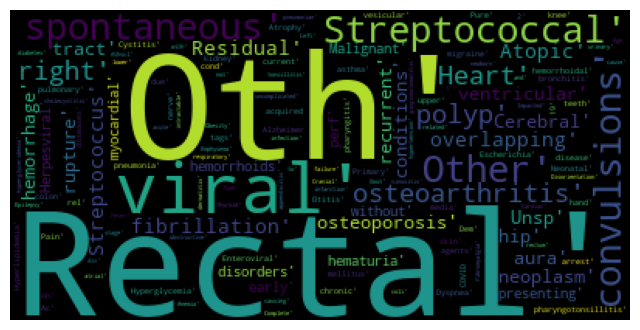

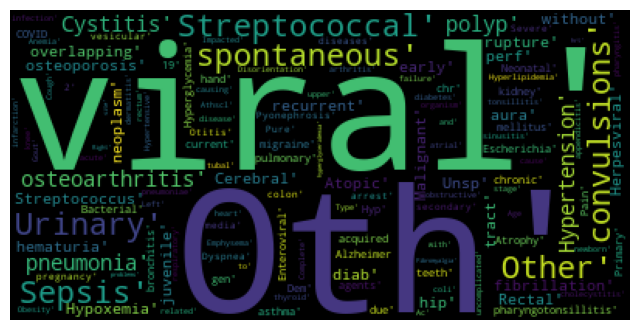

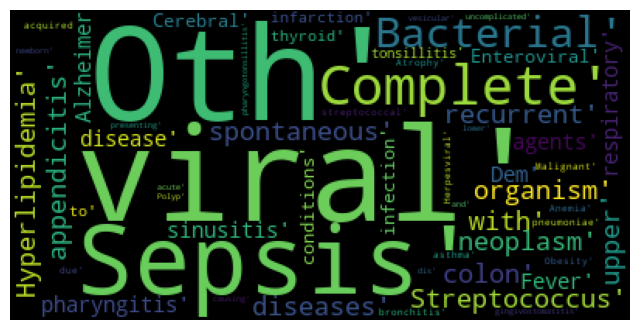

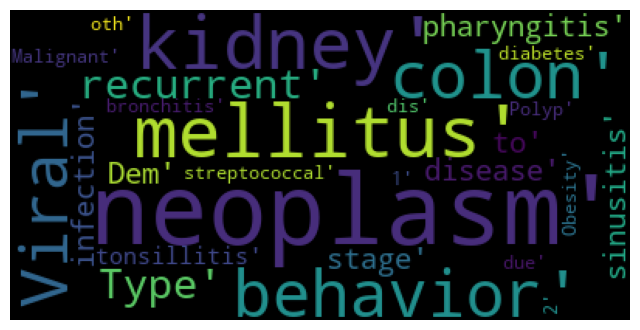

In [572]:
n_clusters = 8
for cluster in range(0,n_clusters):
    df_cluster =grp_df_principal[grp_df_principal['cluster'] == cluster]
    diag_cloud = df_cluster['word_cloud'].head(100).apply(str).str.cat(sep=', ')
    #Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(diag_cloud)

    #Use matplotlib.pyplot to display the fitted wordcloud
    #Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis('off')
    plt.show()